## Configuración inicial

In [16]:
# CELDA 1: Imports y sys.path
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
import torch
import joblib

# asegurarse de poder importar src
sys.path.append(os.path.abspath("../src"))

from utils.processing import (
    load_processed,
    add_returns_volatility,
    features_for_clustering,
    scale_features,
)
from utils.clustering import (
    kmeans_cluster,
    dbscan_cluster,
    hierarchical_cluster,
    plot_clusters_2d,
    cluster_each_coin,
)
from utils.rnn_models import (
    TorchRNN,
    make_windowed_multivariate,
    prepare_features,
    train_torch_rnn,
    invert_scaling,
    train_crypto_model,
)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

PyTorch device: cpu


## Carga y procesamiento de datos

In [2]:
# CELDA 2: Cargar archivos (verificar rutas)
btc_api = load_processed("../data/processed/bitcoin_api.csv")
eth_api = load_processed("../data/processed/ethereum_api.csv")
bnb_api = load_processed("../data/processed/binancecoin_api.csv")
btc_csv = load_processed("../data/processed/bitcoin_csv.csv")
eth_csv = load_processed("../data/processed/ethereum_csv.csv")
bnb_csv = load_processed("../data/processed/binancecoin_csv.csv")

# quick checks
print("Registros cargados:")
print("btc_api:", len(btc_api), "btc_csv:", len(btc_csv))
print("eth_api:", len(eth_api), "eth_csv:", len(eth_csv))
print("bnb_api:", len(bnb_api), "bnb_csv:", len(bnb_csv))
print("\nColumnas BTC API:", btc_api.columns.tolist())


Registros cargados:
btc_api: 180 btc_csv: 2991
eth_api: 180 eth_csv: 2160
bnb_api: 180 bnb_csv: 1442

Columnas BTC API: ['date', 'coin', 'open', 'high', 'low', 'close', 'volume', 'market_cap', 'source']


### Clusterización de criptomonedas

Procesando: BTC API
BTC API - Clusters asignados, muestra head con cluster id:


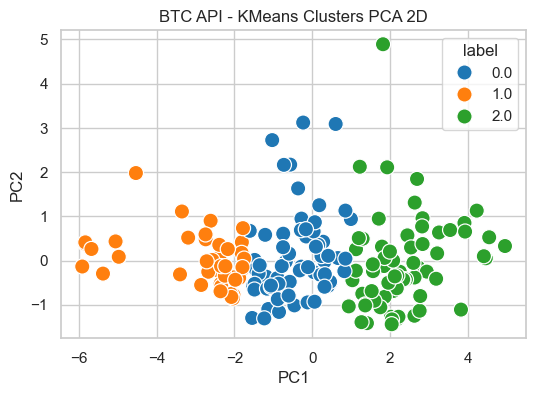

Procesando: ETH API
ETH API - Clusters asignados, muestra head con cluster id:


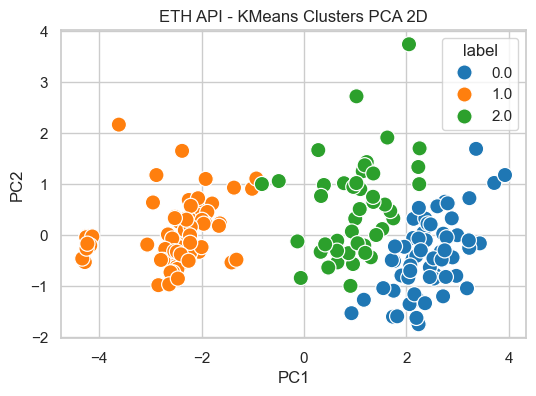

Procesando: BNB API
BNB API - Clusters asignados, muestra head con cluster id:


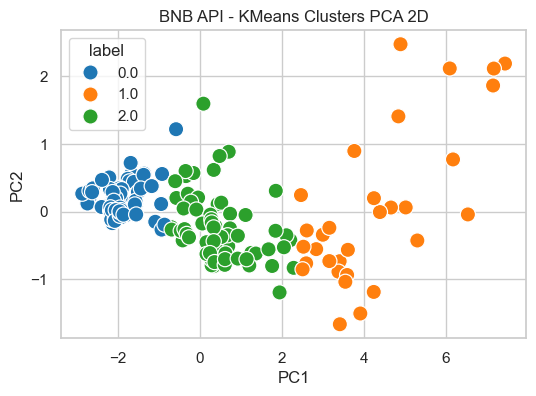

Procesando: BTC CSV
BTC CSV - Clusters asignados, muestra head con cluster id:


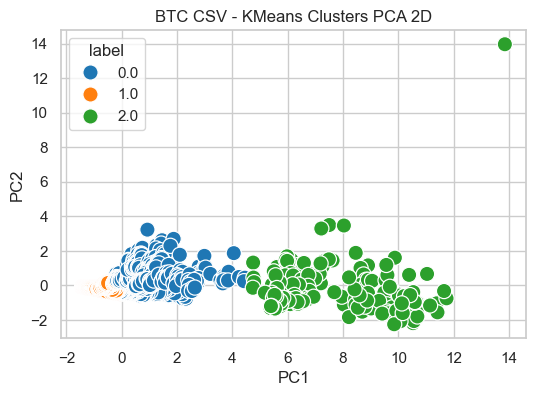

Procesando: ETH CSV
ETH CSV - Clusters asignados, muestra head con cluster id:


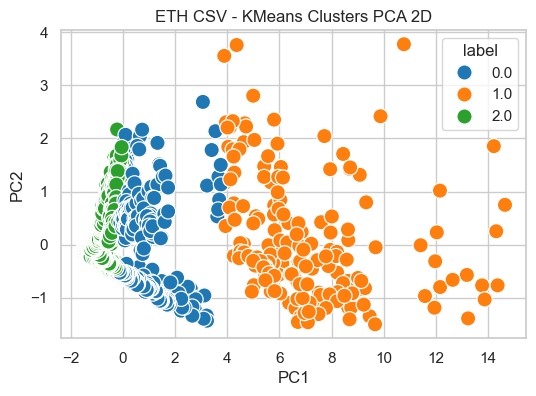

Procesando: BNB CSV
BNB CSV - Clusters asignados, muestra head con cluster id:


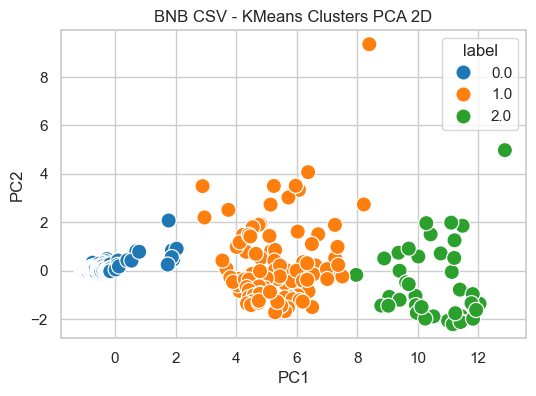

----- Clusterización DBSCAN -----
Procesando: BTC API
BTC API - Clusters asignados con DBSCAN:


,date,coin,open,high,low,close,volume,market_cap,source,cluster
0,2025-04-30,BTC,94256.359463,94256.359463,94256.359463,94256.359463,2.588263e+10,1.870818e+12,API,-1.0
1,2025-05-01,BTC,94235.753310,94235.753310,94235.753310,94235.753310,2.654170e+10,1.871350e+12,API,-1.0
2,2025-05-02,BTC,96426.945223,96426.945223,96426.945223,96426.945223,3.020757e+10,1.914884e+12,API,-1.0
3,2025-05-03,BTC,96855.568134,96855.568134,96855.568134,96855.568134,2.327638e+10,1.923252e+12,API,-1.0
4,2025-05-04,BTC,95922.868424,95922.868424,95922.868424,95922.868424,1.379755e+10,1.904895e+12,API,-1.0


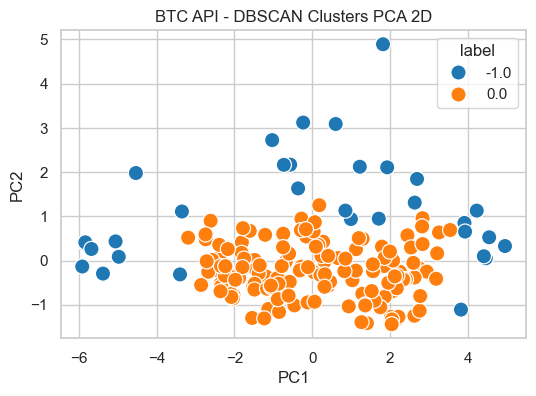

Procesando: ETH API
ETH API - Clusters asignados con DBSCAN:


,date,coin,open,high,low,close,volume,market_cap,source,cluster
0,2025-04-30,ETH,1796.972046,1796.972046,1796.972046,1796.972046,1.399456e+10,2.165969e+11,API,0.0
1,2025-05-01,ETH,1794.049541,1794.049541,1794.049541,1794.049541,1.364463e+10,2.166233e+11,API,0.0
2,2025-05-02,ETH,1838.854329,1838.854329,1838.854329,1838.854329,1.431057e+10,2.219696e+11,API,0.0
3,2025-05-03,ETH,1841.427591,1841.427591,1841.427591,1841.427591,1.168630e+10,2.222690e+11,API,0.0
4,2025-05-04,ETH,1834.501912,1834.501912,1834.501912,1834.501912,6.704990e+09,2.214950e+11,API,0.0


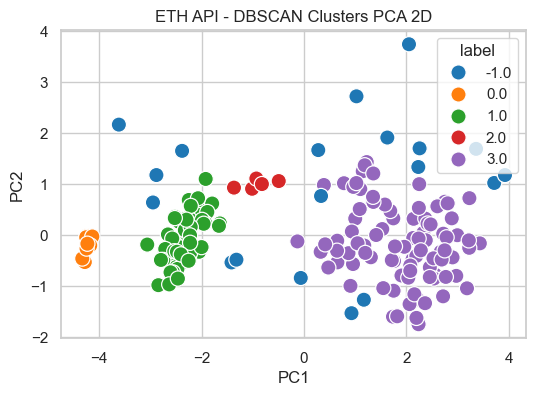

Procesando: BNB API
BNB API - Clusters asignados con DBSCAN:


,date,coin,open,high,low,close,volume,market_cap,source,cluster
0,2025-04-30,BNB,600.588958,600.588958,600.588958,600.588958,7.793351e+08,8.754678e+10,API,0.0
1,2025-05-01,BNB,599.630200,599.630200,599.630200,599.630200,7.177691e+08,8.749990e+10,API,0.0
2,2025-05-02,BNB,599.579691,599.579691,599.579691,599.579691,5.867799e+08,8.747002e+10,API,0.0
3,2025-05-03,BNB,601.324468,601.324468,601.324468,601.324468,6.093209e+08,8.772653e+10,API,0.0
4,2025-05-04,BNB,599.246884,599.246884,599.246884,599.246884,3.839586e+08,8.742052e+10,API,0.0


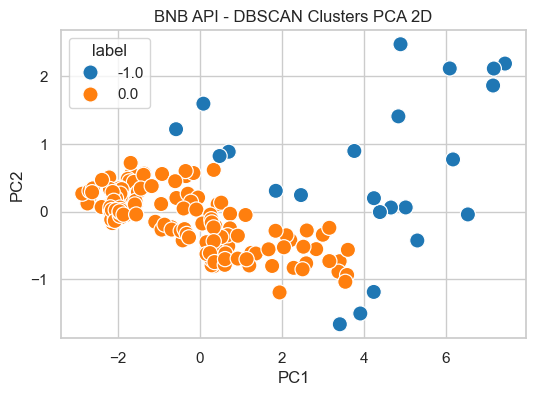

Procesando: BTC CSV
BTC CSV - Clusters asignados con DBSCAN:


,date,coin,open,high,low,close,volume,market_cap,source,cluster
0,2013-04-29,BTC,134.444000,147.488007,134.000000,144.539993,0.0,1.603769e+09,CSV,0.0
1,2013-04-30,BTC,144.000000,146.929993,134.050003,139.000000,0.0,1.542813e+09,CSV,0.0
2,2013-05-01,BTC,139.000000,139.889999,107.720001,116.989998,0.0,1.298955e+09,CSV,0.0
3,2013-05-02,BTC,116.379997,125.599998,92.281898,105.209999,0.0,1.168517e+09,CSV,0.0
4,2013-05-03,BTC,106.250000,108.127998,79.099998,97.750000,0.0,1.085995e+09,CSV,0.0


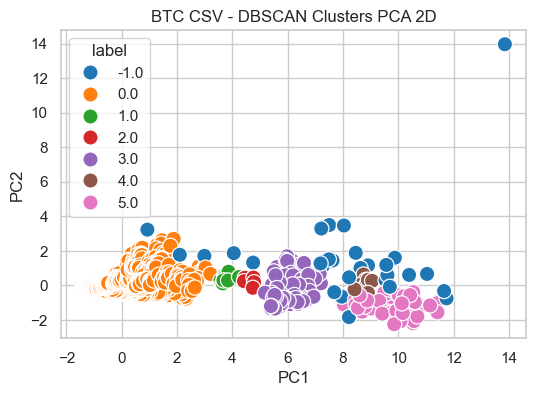

Procesando: ETH CSV
ETH CSV - Clusters asignados con DBSCAN:


,date,coin,open,high,low,close,volume,market_cap,source,cluster
0,2015-08-08,ETH,2.793760,2.798810,0.714725,0.753325,674188.0,4.548689e+07,CSV,0.0
1,2015-08-09,ETH,0.706136,0.879810,0.629191,0.701897,532170.0,4.239957e+07,CSV,0.0
2,2015-08-10,ETH,0.713989,0.729854,0.636546,0.708448,405283.0,4.281836e+07,CSV,0.0
3,2015-08-11,ETH,0.708087,1.131410,0.663235,1.067860,1463100.0,6.456929e+07,CSV,0.0
4,2015-08-12,ETH,1.058750,1.289940,0.883608,1.217440,2150620.0,7.364501e+07,CSV,0.0


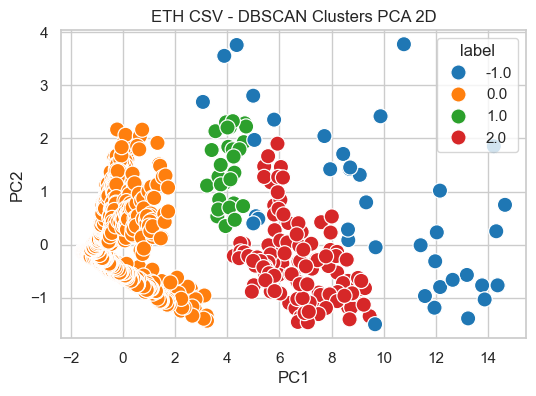

Procesando: BNB CSV
BNB CSV - Clusters asignados con DBSCAN:


,date,coin,open,high,low,close,volume,market_cap,source,cluster
0,2017-07-26,BNB,0.105893,0.109013,0.099266,0.105138,200395.0,10513800.0,CSV,0.0
1,2017-07-27,BNB,0.105108,0.108479,0.100888,0.107737,344499.0,10773700.0,CSV,0.0
2,2017-07-28,BNB,0.107632,0.109019,0.101473,0.104067,342568.0,10406700.0,CSV,0.0
3,2017-07-29,BNB,0.104782,0.111264,0.101108,0.107811,340218.0,10781100.0,CSV,0.0
4,2017-07-30,BNB,0.107935,0.108138,0.103162,0.106414,224261.0,10641400.0,CSV,0.0


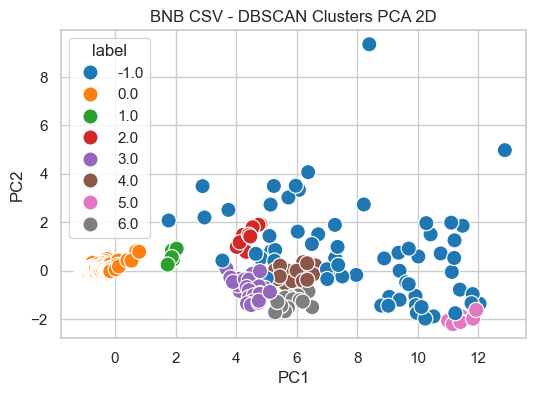

----- Clusterización Jerárquica (Agglomerative) -----
Procesando: BTC API
BTC API - Clusters asignados con Jerárquico:


,date,coin,open,high,low,close,volume,market_cap,source,cluster
0,2025-04-30,BTC,94256.359463,94256.359463,94256.359463,94256.359463,2.588263e+10,1.870818e+12,API,2.0
1,2025-05-01,BTC,94235.753310,94235.753310,94235.753310,94235.753310,2.654170e+10,1.871350e+12,API,2.0
2,2025-05-02,BTC,96426.945223,96426.945223,96426.945223,96426.945223,3.020757e+10,1.914884e+12,API,2.0
3,2025-05-03,BTC,96855.568134,96855.568134,96855.568134,96855.568134,2.327638e+10,1.923252e+12,API,2.0
4,2025-05-04,BTC,95922.868424,95922.868424,95922.868424,95922.868424,1.379755e+10,1.904895e+12,API,2.0


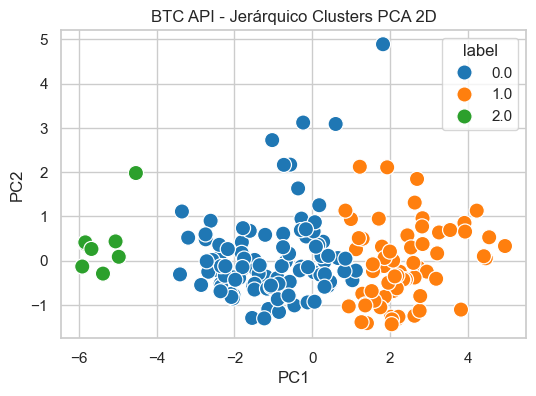

Procesando: ETH API
ETH API - Clusters asignados con Jerárquico:


,date,coin,open,high,low,close,volume,market_cap,source,cluster
0,2025-04-30,ETH,1796.972046,1796.972046,1796.972046,1796.972046,1.399456e+10,2.165969e+11,API,1.0
1,2025-05-01,ETH,1794.049541,1794.049541,1794.049541,1794.049541,1.364463e+10,2.166233e+11,API,1.0
2,2025-05-02,ETH,1838.854329,1838.854329,1838.854329,1838.854329,1.431057e+10,2.219696e+11,API,1.0
3,2025-05-03,ETH,1841.427591,1841.427591,1841.427591,1841.427591,1.168630e+10,2.222690e+11,API,1.0
4,2025-05-04,ETH,1834.501912,1834.501912,1834.501912,1834.501912,6.704990e+09,2.214950e+11,API,1.0


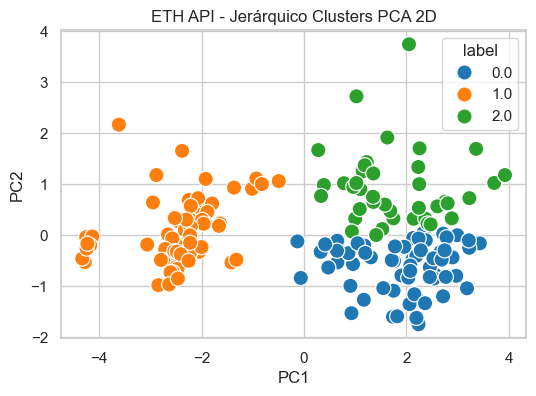

Procesando: BNB API
BNB API - Clusters asignados con Jerárquico:


,date,coin,open,high,low,close,volume,market_cap,source,cluster
0,2025-04-30,BNB,600.588958,600.588958,600.588958,600.588958,7.793351e+08,8.754678e+10,API,2.0
1,2025-05-01,BNB,599.630200,599.630200,599.630200,599.630200,7.177691e+08,8.749990e+10,API,2.0
2,2025-05-02,BNB,599.579691,599.579691,599.579691,599.579691,5.867799e+08,8.747002e+10,API,2.0
3,2025-05-03,BNB,601.324468,601.324468,601.324468,601.324468,6.093209e+08,8.772653e+10,API,2.0
4,2025-05-04,BNB,599.246884,599.246884,599.246884,599.246884,3.839586e+08,8.742052e+10,API,2.0


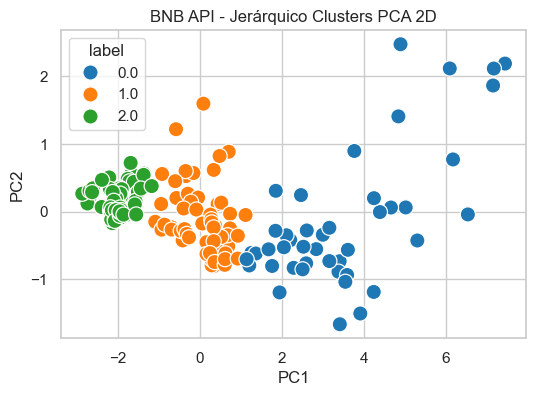

Procesando: BTC CSV
BTC CSV - Clusters asignados con Jerárquico:


,date,coin,open,high,low,close,volume,market_cap,source,cluster
0,2013-04-29,BTC,134.444000,147.488007,134.000000,144.539993,0.0,1.603769e+09,CSV,1.0
1,2013-04-30,BTC,144.000000,146.929993,134.050003,139.000000,0.0,1.542813e+09,CSV,1.0
2,2013-05-01,BTC,139.000000,139.889999,107.720001,116.989998,0.0,1.298955e+09,CSV,1.0
3,2013-05-02,BTC,116.379997,125.599998,92.281898,105.209999,0.0,1.168517e+09,CSV,1.0
4,2013-05-03,BTC,106.250000,108.127998,79.099998,97.750000,0.0,1.085995e+09,CSV,1.0


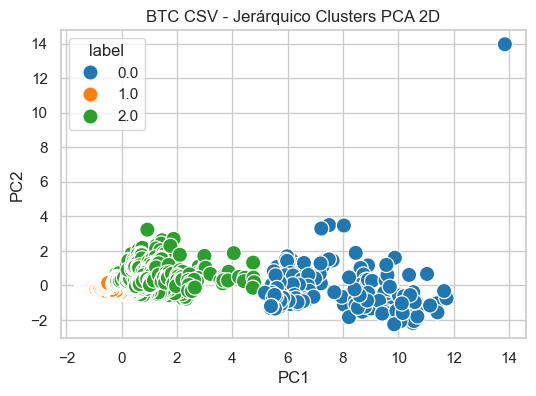

Procesando: ETH CSV
ETH CSV - Clusters asignados con Jerárquico:


,date,coin,open,high,low,close,volume,market_cap,source,cluster
0,2015-08-08,ETH,2.793760,2.798810,0.714725,0.753325,674188.0,4.548689e+07,CSV,2.0
1,2015-08-09,ETH,0.706136,0.879810,0.629191,0.701897,532170.0,4.239957e+07,CSV,2.0
2,2015-08-10,ETH,0.713989,0.729854,0.636546,0.708448,405283.0,4.281836e+07,CSV,2.0
3,2015-08-11,ETH,0.708087,1.131410,0.663235,1.067860,1463100.0,6.456929e+07,CSV,2.0
4,2015-08-12,ETH,1.058750,1.289940,0.883608,1.217440,2150620.0,7.364501e+07,CSV,2.0


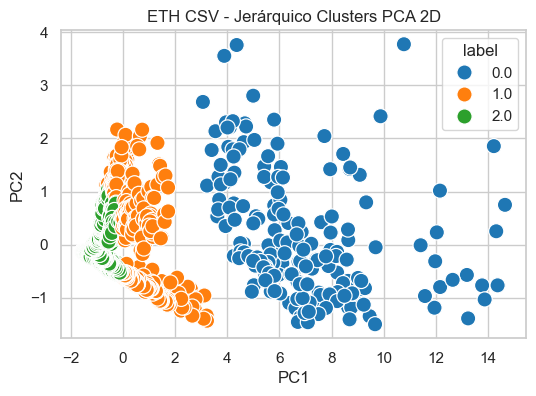

Procesando: BNB CSV
BNB CSV - Clusters asignados con Jerárquico:


,date,coin,open,high,low,close,volume,market_cap,source,cluster
0,2017-07-26,BNB,0.105893,0.109013,0.099266,0.105138,200395.0,10513800.0,CSV,1.0
1,2017-07-27,BNB,0.105108,0.108479,0.100888,0.107737,344499.0,10773700.0,CSV,1.0
2,2017-07-28,BNB,0.107632,0.109019,0.101473,0.104067,342568.0,10406700.0,CSV,1.0
3,2017-07-29,BNB,0.104782,0.111264,0.101108,0.107811,340218.0,10781100.0,CSV,1.0
4,2017-07-30,BNB,0.107935,0.108138,0.103162,0.106414,224261.0,10641400.0,CSV,1.0


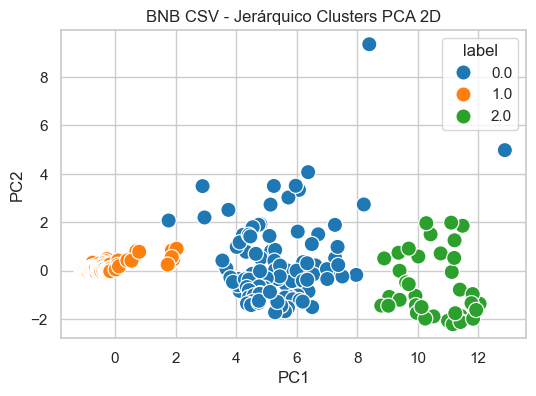

In [3]:
# Lista de dataframes y labels
dataframes = {
    "BTC API": btc_api,
    "ETH API": eth_api,
    "BNB API": bnb_api,
    "BTC CSV": btc_csv,
    "ETH CSV": eth_csv,
    "BNB CSV": bnb_csv
}

# Columnas relevantes para clustering
features = ["open", "high", "low", "close", "volume", "market_cap"]

for label, df in dataframes.items():
    print(f"Procesando: {label}")

    # Seleccionar features numéricos
    X = df[features]

    # Escalar
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features, index=df.index)

    # Usar la función cluster_each_coin para asignar clusters individualmente por moneda
    df_clustered = cluster_each_coin(X=X_scaled, original_df=df, method="kmeans", k=3)

    # Mostrar silhouette score aproximado para todo (promedio por moneda puede hacerse si quieres)
    print(f"{label} - Clusters asignados, muestra head con cluster id:")

    # Visualización PCA con clusters
    pca = PCA(n_components=2)
    X_pca = pd.DataFrame(pca.fit_transform(X_scaled), columns=["PC1", "PC2"], index=df.index)

    plot_clusters_2d(X_pca, df_clustered["cluster"], title=f"{label} - KMeans Clusters PCA 2D")
    
    
# Clusterización con DBSCAN
print("----- Clusterización DBSCAN -----")
for label, df in dataframes.items():
    print(f"Procesando: {label}")

    X = df[features]
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features, index=df.index)

    df_clustered = cluster_each_coin(X=X_scaled, original_df=df, method="dbscan", eps=0.5, min_samples=5)

    print(f"{label} - Clusters asignados con DBSCAN:")
    display(df_clustered.head())

    pca = PCA(n_components=2)
    X_pca = pd.DataFrame(pca.fit_transform(X_scaled), columns=["PC1", "PC2"], index=df.index)

    plot_clusters_2d(X_pca, df_clustered["cluster"], title=f"{label} - DBSCAN Clusters PCA 2D")

# Clusterización jerárquica (Agglomerative)
print("----- Clusterización Jerárquica (Agglomerative) -----")
for label, df in dataframes.items():
    print(f"Procesando: {label}")

    X = df[features]
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features, index=df.index)

    df_clustered = cluster_each_coin(X=X_scaled, original_df=df, method="hierarchical", k=3, linkage="ward")

    print(f"{label} - Clusters asignados con Jerárquico:")
    display(df_clustered.head())

    pca = PCA(n_components=2)
    X_pca = pd.DataFrame(pca.fit_transform(X_scaled), columns=["PC1", "PC2"], index=df.index)

    plot_clusters_2d(X_pca, df_clustered["cluster"], title=f"{label} - Jerárquico Clusters PCA 2D")



## Modelos de predicción


🟢 Entrenando modelo para Bitcoin...

Early stopping at epoch 102 | Best loss: 0.000063
📊 Bitcoin | MAE: 6437.28, RMSE: 10148.95


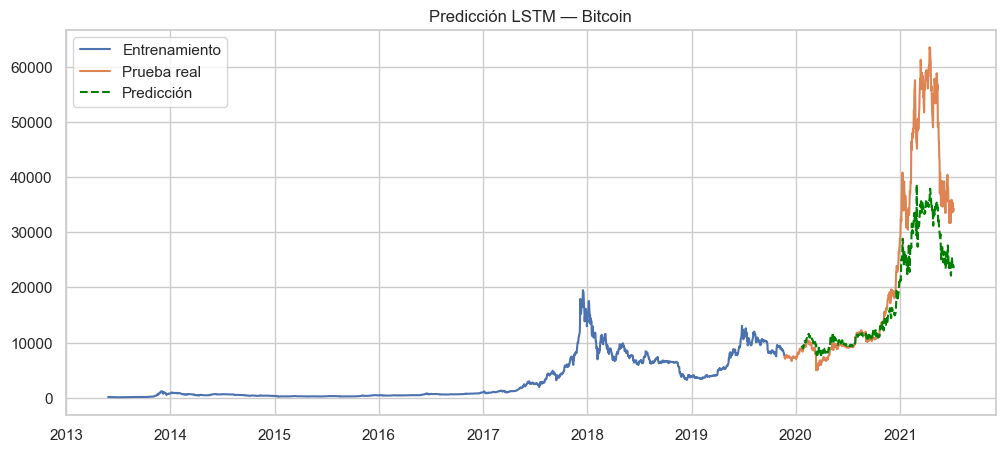


🟢 Entrenando modelo para Ethereum...

Early stopping at epoch 35 | Best loss: 0.000247
📊 Ethereum | MAE: 270.53, RMSE: 434.24


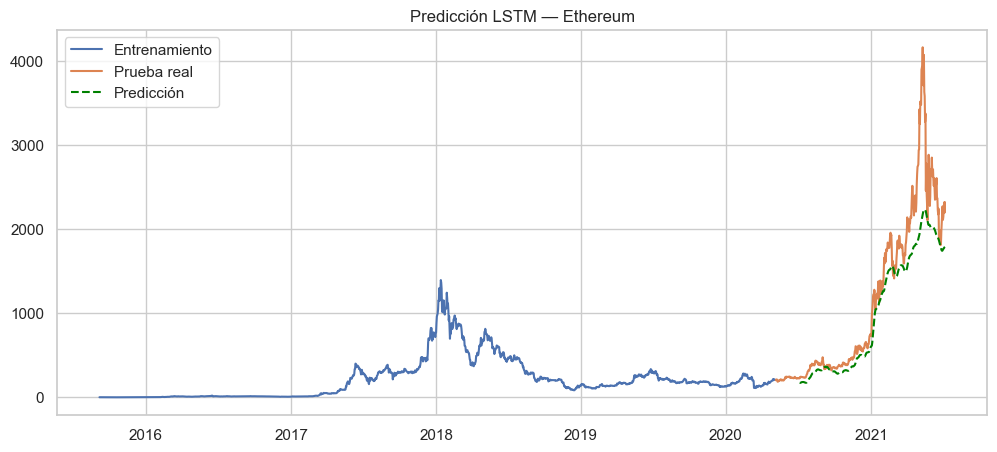


🟢 Entrenando modelo para BinanceCoin...

Early stopping at epoch 17 | Best loss: 0.000172
📊 BinanceCoin | MAE: 231.00, RMSE: 299.82


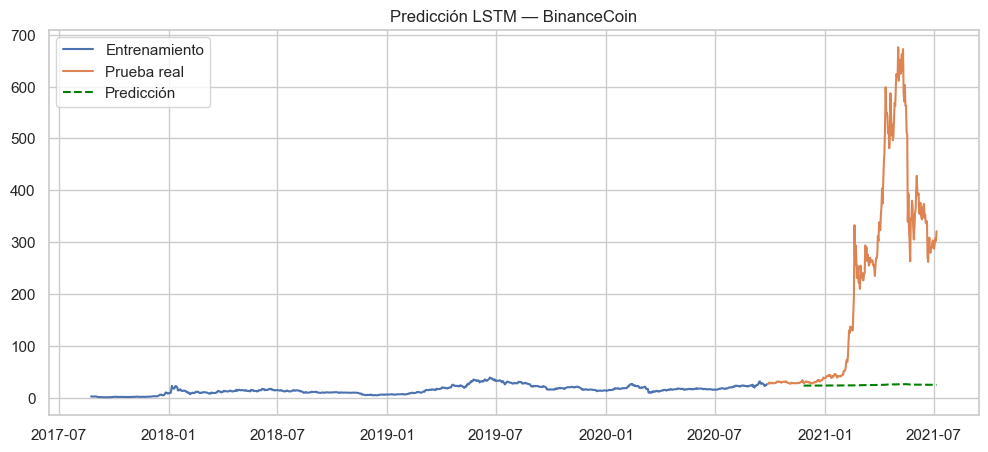

In [4]:
model_btc, scaler_btc, btc_scaled = train_crypto_model(btc_csv, "Bitcoin")
model_eth, scaler_eth, eth_scaled = train_crypto_model(eth_csv, "Ethereum")
model_bnb, scaler_bnb, bnb_scaled = train_crypto_model(bnb_csv, "BinanceCoin")

In [17]:
# Guardar modelos PyTorch
torch.save(model_btc.state_dict(), "models/model_btc.pth")
torch.save(model_eth.state_dict(), "models/model_eth.pth")
torch.save(model_bnb.state_dict(), "models/model_bnb.pth")

# Guardar scalers y data escalada con joblib
joblib.dump(scaler_btc, "models/scaler_btc.joblib")
joblib.dump(scaler_eth, "models/scaler_eth.joblib")
joblib.dump(scaler_bnb, "models/scaler_bnb.joblib")

btc_scaled.to_csv("models/btc_scaled.csv")
eth_scaled.to_csv("models/eth_scaled.csv")
bnb_scaled.to_csv("models/bnb_scaled.csv")

print("Modelos, scalers y datos escalados guardados exitosamente.")

Modelos, scalers y datos escalados guardados exitosamente.


In [18]:
# Crear instancia del modelo (igual que se definiò originalmente)
model_btc = TorchRNN(input_size=6, hidden_size=128, num_layers=3, rnn_type="LSTM").to(DEVICE)
model_eth = TorchRNN(input_size=6, hidden_size=128, num_layers=3, rnn_type="LSTM").to(DEVICE)
model_bnb = TorchRNN(input_size=6, hidden_size=128, num_layers=3, rnn_type="LSTM").to(DEVICE)

# Cargar pesos entrenados
model_btc.load_state_dict(torch.load("models/model_btc.pth", map_location=DEVICE))
model_eth.load_state_dict(torch.load("models/model_eth.pth", map_location=DEVICE))
model_bnb.load_state_dict(torch.load("models/model_bnb.pth", map_location=DEVICE))

model_btc.eval()
model_eth.eval()
model_bnb.eval()

# Cargar scalers
scaler_btc = joblib.load("models/scaler_btc.joblib")
scaler_eth = joblib.load("models/scaler_eth.joblib")
scaler_bnb = joblib.load("models/scaler_bnb.joblib")

# Cargar datos escalados
btc_scaled = pd.read_csv("models/btc_scaled.csv", index_col=0)
eth_scaled = pd.read_csv("models/eth_scaled.csv", index_col=0)
bnb_scaled = pd.read_csv("models/bnb_scaled.csv", index_col=0)

print("Modelos, scalers y datos cargados correctamente")

Modelos, scalers y datos cargados correctamente


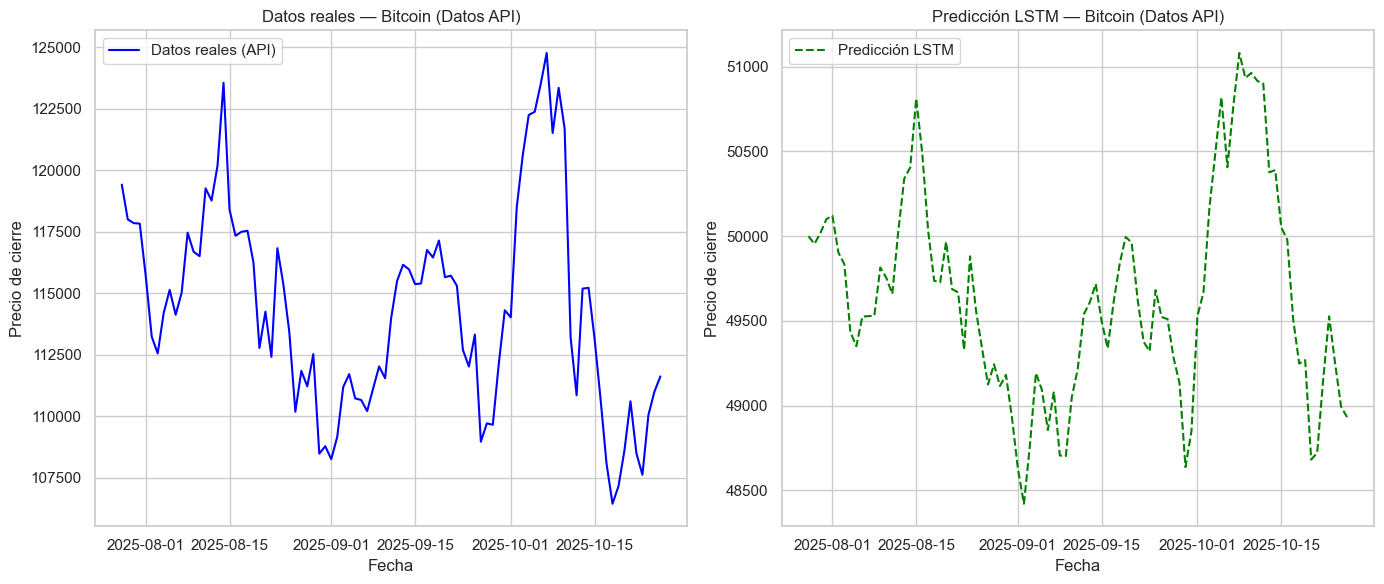

MAE (API): 64753.15, RMSE (API): 64863.12


In [19]:
# 1️⃣ Cargar y preparar los datos del API
# Preparamos las mismas características usadas durante el entrenamiento
btc_api_feat = prepare_features(btc_api)
features_fit = ["close", "log_return", "volatility", "volume", "ma_7d", "ma_30d"]

# 2️⃣ Escalar con el mismo scaler del modelo entrenado
btc_api_for_scale = btc_api_feat[features_fit]
btc_api_scaled = pd.DataFrame(
    scaler_btc.transform(btc_api_for_scale),  # Usa el scaler correspondiente
    columns=features_fit,
    index=btc_api_feat.index
)

# 3️⃣ Crear las ventanas de tiempo (igual que en el entrenamiento)
X_api, y_api = make_windowed_multivariate(btc_api_scaled, "close", window=60)

# 4️⃣ Generar predicciones con el modelo cargado
model_btc.eval()
with torch.no_grad():
    X_api_torch = torch.tensor(X_api, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
    preds_scaled_api = model_btc(X_api_torch).cpu().numpy().flatten()

# 5️⃣ Desescalar predicciones y valores reales
preds_api = invert_scaling(preds_scaled_api, scaler_btc, btc_api_scaled, "close")
y_api_real = invert_scaling(y_api, scaler_btc, btc_api_scaled, "close")

# 6️⃣ Visualización lado a lado
plt.figure(figsize=(14, 6))

# Datos reales
plt.subplot(1, 2, 1)
plt.plot(btc_api_feat.index[-len(y_api_real):], y_api_real, label="Datos reales (API)", color="blue")
plt.title("Datos reales — Bitcoin (Datos API)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.legend()

# Predicciones
plt.subplot(1, 2, 2)
plt.plot(btc_api_feat.index[-len(preds_api):], preds_api, label="Predicción LSTM", color="green", linestyle="--")
plt.title("Predicción LSTM — Bitcoin (Datos API)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.legend()

plt.tight_layout()
plt.show()

# 7️⃣ Métricas de desempeño
mae_api = mean_absolute_error(y_api_real, preds_api)
rmse_api = np.sqrt(mean_squared_error(y_api_real, preds_api))
print(f"MAE (API): {mae_api:.2f}, RMSE (API): {rmse_api:.2f}")


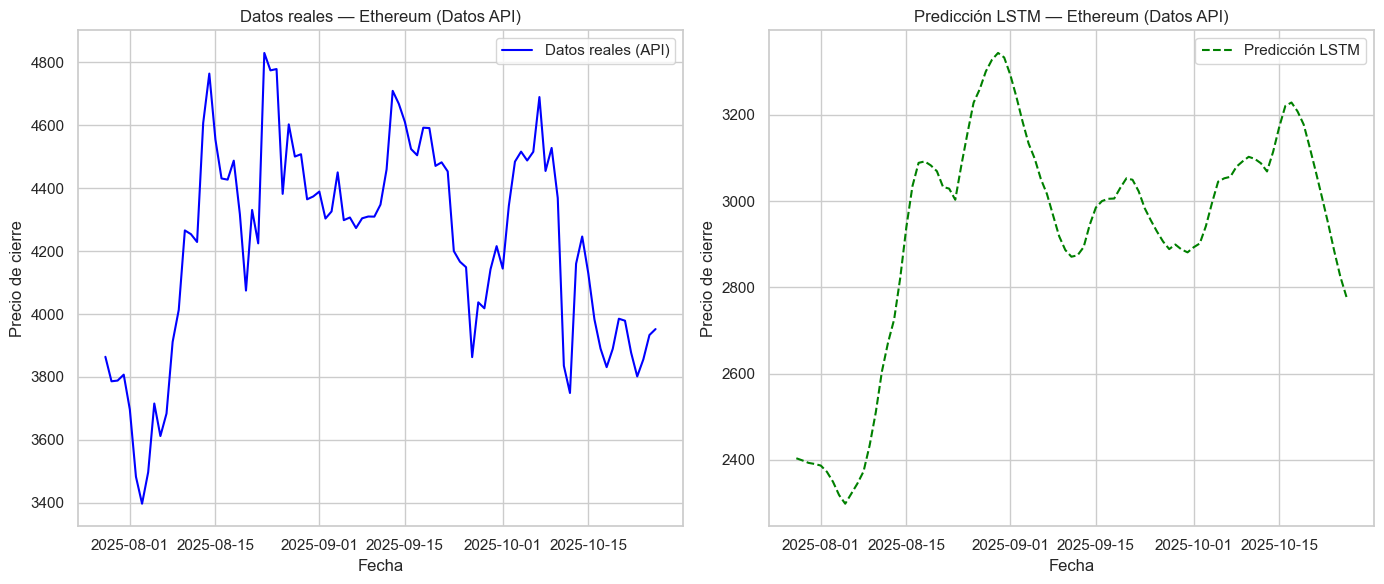

MAE (API): 1295.28, RMSE (API): 1326.01


In [21]:
# 1️⃣ Cargar y preparar los datos del API
# Preparamos las mismas características usadas durante el entrenamiento
eth_api_feat = prepare_features(eth_api)
features_fit = ["close", "log_return", "volatility", "volume", "ma_7d", "ma_30d"]

# 2️⃣ Escalar con el mismo scaler del modelo entrenado
eth_api_for_scale = eth_api_feat[features_fit]
eth_api_scaled = pd.DataFrame(
    scaler_btc.transform(eth_api_for_scale),  # Usa el scaler correspondiente
    columns=features_fit,
    index=eth_api_feat.index
)

# 3️⃣ Crear las ventanas de tiempo (igual que en el entrenamiento)
X_api, y_api = make_windowed_multivariate(eth_api_scaled, "close", window=60)

# 4️⃣ Generar predicciones con el modelo cargado
model_eth.eval()
with torch.no_grad():
    X_api_torch = torch.tensor(X_api, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
    preds_scaled_api = model_eth(X_api_torch).cpu().numpy().flatten()

# 5️⃣ Desescalar predicciones y valores reales
preds_api = invert_scaling(preds_scaled_api, scaler_btc, eth_api_scaled, "close")
y_api_real = invert_scaling(y_api, scaler_btc, eth_api_scaled, "close")

# 6️⃣ Visualización lado a lado
plt.figure(figsize=(14, 6))

# Datos reales
plt.subplot(1, 2, 1)
plt.plot(btc_api_feat.index[-len(y_api_real):], y_api_real, label="Datos reales (API)", color="blue")
plt.title("Datos reales — Ethereum (Datos API)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.legend()

# Predicciones
plt.subplot(1, 2, 2)
plt.plot(btc_api_feat.index[-len(preds_api):], preds_api, label="Predicción LSTM", color="green", linestyle="--")
plt.title("Predicción LSTM — Ethereum (Datos API)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.legend()

plt.tight_layout()
plt.show()

# 7️⃣ Métricas de desempeño
mae_api = mean_absolute_error(y_api_real, preds_api)
rmse_api = np.sqrt(mean_squared_error(y_api_real, preds_api))
print(f"MAE (API): {mae_api:.2f}, RMSE (API): {rmse_api:.2f}")


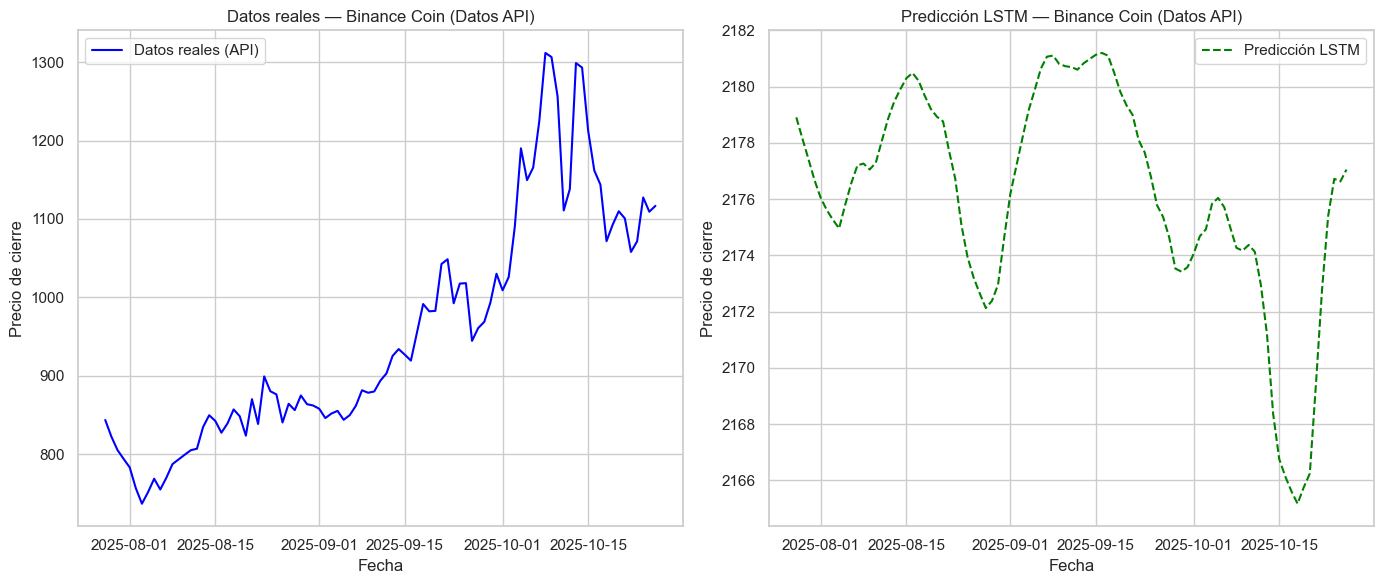

MAE (API): 1222.28, RMSE (API): 1231.46


In [22]:
# 1️⃣ Cargar y preparar los datos del API
# Preparamos las mismas características usadas durante el entrenamiento
bnb_api_feat = prepare_features(bnb_api)
features_fit = ["close", "log_return", "volatility", "volume", "ma_7d", "ma_30d"]

# 2️⃣ Escalar con el mismo scaler del modelo entrenado
bnb_api_for_scale = bnb_api_feat[features_fit]
bnb_api_scaled = pd.DataFrame(
    scaler_btc.transform(bnb_api_for_scale),  # Usa el scaler correspondiente
    columns=features_fit,
    index=bnb_api_feat.index
)

# 3️⃣ Crear las ventanas de tiempo (igual que en el entrenamiento)
X_api, y_api = make_windowed_multivariate(bnb_api_scaled, "close", window=60)

# 4️⃣ Generar predicciones con el modelo cargado
model_bnb.eval()
with torch.no_grad():
    X_api_torch = torch.tensor(X_api, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
    preds_scaled_api = model_bnb(X_api_torch).cpu().numpy().flatten()

# 5️⃣ Desescalar predicciones y valores reales
preds_api = invert_scaling(preds_scaled_api, scaler_btc, eth_api_scaled, "close")
y_api_real = invert_scaling(y_api, scaler_btc, eth_api_scaled, "close")

# 6️⃣ Visualización lado a lado
plt.figure(figsize=(14, 6))

# Datos reales
plt.subplot(1, 2, 1)
plt.plot(btc_api_feat.index[-len(y_api_real):], y_api_real, label="Datos reales (API)", color="blue")
plt.title("Datos reales — Binance Coin (Datos API)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.legend()

# Predicciones
plt.subplot(1, 2, 2)
plt.plot(btc_api_feat.index[-len(preds_api):], preds_api, label="Predicción LSTM", color="green", linestyle="--")
plt.title("Predicción LSTM — Binance Coin (Datos API)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.legend()

plt.tight_layout()
plt.show()

# 7️⃣ Métricas de desempeño
mae_api = mean_absolute_error(y_api_real, preds_api)
rmse_api = np.sqrt(mean_squared_error(y_api_real, preds_api))
print(f"MAE (API): {mae_api:.2f}, RMSE (API): {rmse_api:.2f}")
